# A simple coefficient of correlation between two numeric series

This notebook models the numeric constraints expressed in the [_A new coefficient of correlation_](https://arxiv.org/abs/1909.10140) paper,
and it shows how such coefficient varies when we compare two simple data series with increasing levels of noise.

In [14]:
import math

from random import randint
from functools import reduce
from typing import Iterable, Tuple

import numpy as np
import matplotlib.pyplot as plt

**Given**:

- $(X, Y)$: pair of random variables
- $(X_1, Y_1), ..., (X_n, Y_n)$: $n$ samples of $(X, Y)$

Sort by $X$: $(X_{(1)}, Y_{(1)}), ..., (X_{(n)}, Y_{(n)})$ such that $X_{(i)} \leq X_{(j)}$ $\forall i \leq j$

Define $r_i$ as the rank of $Y_{(i)}$ as $r_i = count(j)  : Y_{(j)} \leq Y_{(i)}$

Similarly, define $l_i = count(j) : Y_{(j)} \geq Y_{(i)}$:

Then:

$$
\xi_n(X, Y) = 1 - \frac{n \sum_{i=1}^{n-1} |r_{i+1} - r_{i}|}{2 \sum_{i=1}^{n} l_i(n-l_i)}
$$

In [4]:
def corr(x: Iterable[float], y: Iterable[float]) -> float:
    """
    Calculates the correlation coefficient (between 0-1)
    between two numeric series X and Y.
    """
    assert len(x) == len(y), 'x and y have different lengths'
    data = list(zip(x, y))
    n = len(data)
    data = sorted(data, key=lambda d: d[0])
    sorted_y = sorted(d[1] for d in data)

    # (Right) ranks of Y
    r_rank_y = reduce(lambda m, i: {
        **m, sorted_y[i]: m.get(sorted_y[i], i) + 1
    }, range(n), {})

    r = [r_rank_y[d[1]] for d in data]

    # (Left) ranks of Y
    l_rank_y = reduce(lambda m, i: {
        **m, sorted_y[n-i-1]: m.get(sorted_y[n-i-1], i) + 1
    }, range(n), {})

    l = [l_rank_y[d[1]] for d in data]

    num = reduce(lambda s, i: s + abs(r[i+1] - r[i]), range(n-1))
    den = reduce(lambda s, i: s + l[i] * (n - l[i]), range(n))
    return max(0, 1 - ((n * num) / (2 * den)))


Let's test this correlation score against two data series of length $n$ defined as it follows:

$X_i = i$ (simple identity series)

$Y_i = X_i + \lambda \rho_i$

Where $\lambda$ is the _noise level_ (between 0 and 1) and $\rho$ is a series of random values.

In other words, $Y$ is mapped to the elements in $X$, plus/minus a certain amount of noise calibrated by a noise level parameter.

Let's define a simple function to generate a noisy signal from a starting data series.

In [224]:
def generate_noise(x: Iterable[float], level: float) -> Iterable[float]:
    """
    Add noise with the specified level to an input data series.

    :param x: Input data series.
    :param level: Output noise level, between 0 (no noise) and 1 (max).
    :return: Noisy data series.
    """
    n = len(x)
    m = int(max(x) - min(x))
    noise = [randint(-m, m) for _ in x]
    modulated_noise = [randint(int(-i/2), int(i/2)) for i in x]
    return [x_ + (level/6 * noise[i]) + (level/2 * modulated_noise[i]) for i, x_ in enumerate(x)]

Some utility plot function:

In [156]:
def plot(x, y, corr=None, title=None):
    plt.plot(y, color='C1')
    plt.plot(x, color='C4')
    if not title:
        title = ''
    if corr is not None:
        title += '\nCorrelation: {:.2f}%'.format(c * 100)
    plt.title(title)
    plt.show()


Let's now plot how the correlation score between the identity series and its noisy version vary when the noise level varies.

In [104]:
# Number of elements in the data series
n = 1000

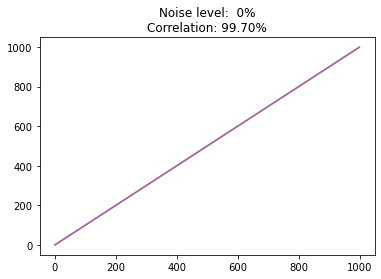

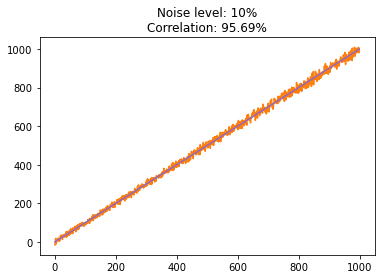

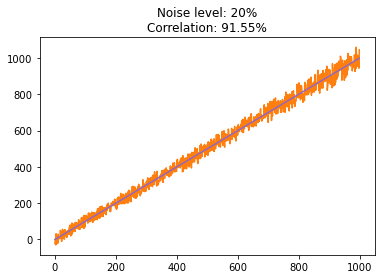

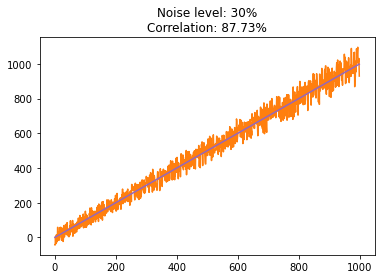

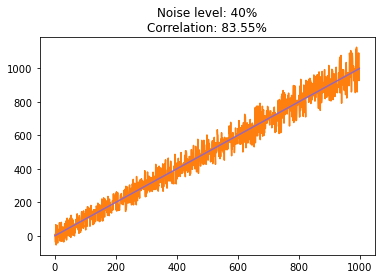

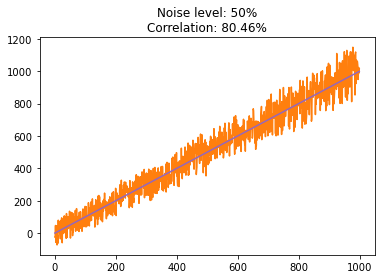

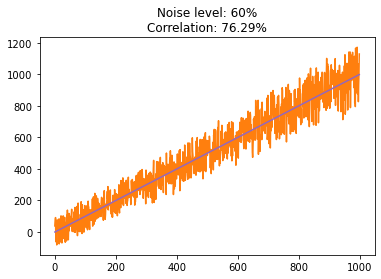

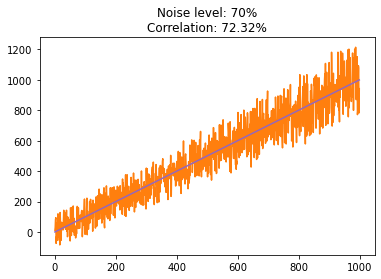

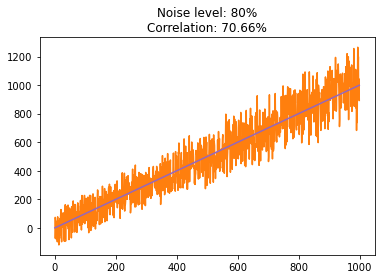

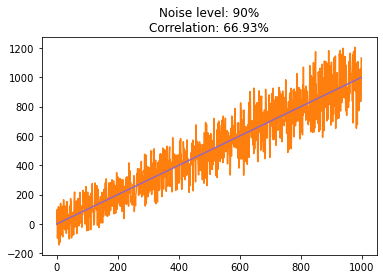

In [225]:
# Define X as a linear variable over the range [0, 1000]
X = range(n)

for noise_level in range(0, 100, 10):
    # Define Y as X + (noise_level * noise)
    Y = generate_noise(X, level=noise_level/100)
    c = corr(X, Y)
    plot(X, Y, corr=c, title='Noise level: {:2d}%'.format(noise_level))

And this is how our reference series relates to a series with completely random values.

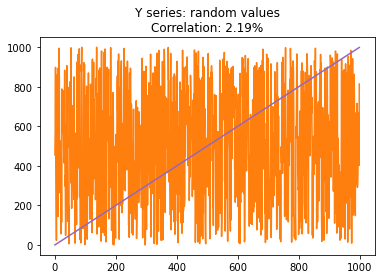

In [205]:
X = range(n)
# Define a Y series with completely random values
Y = [randint(0, n) for _ in range(n)]
c = corr(X, Y)

plot(X, Y, corr=c, title='Y series: random values')

Note that a correlation score of zero in case of complete independence (and a score of one in case of complete functional dependence)
are convergence limits when $n \rightarrow \infty$ - i.e. $\xi(X, Y) = \xi_n(X, Y)$.

In other words: the more samples, the more accurate the coefficient.

An impressive achievement of this technique is that it can detect functional dependencies between two variables even when their associated
functions have opposite slope - an area where previous coefficients that dependended on monotonic analysis performed poorly:

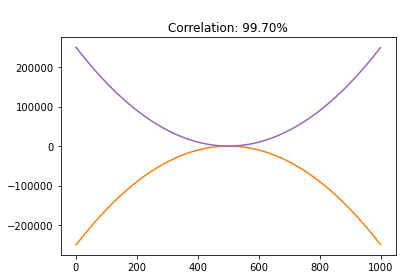

In [231]:
X = np.array([i*i for i in range(int(-n/2), int(n/2))])
Y = -X
c = corr(X, Y)

plot(X, Y, corr=c)

And it's also robust against shifts:

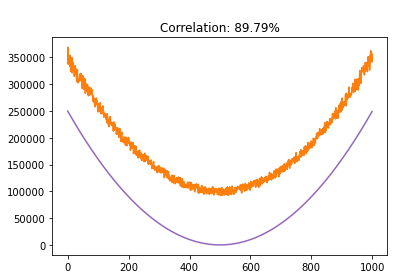

In [228]:
X = [i*i for i in range(int(-n/2), int(n/2))]
Y = [i+1e5 for i in generate_noise(X, level=0.2)]
c = corr(X, Y)

plot(X, Y, corr=c)

And it also seems to perform well with exponential variables:

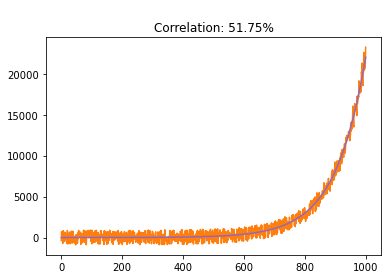

In [229]:
X = np.exp(np.linspace(0, int(n/100), n))
Y = generate_noise(X, level=0.25)
c = corr(X, Y)

plot(X, Y, corr=c)

It's also quite good at recognizing correlations between a clean signal and the
same version of the signal with noise:

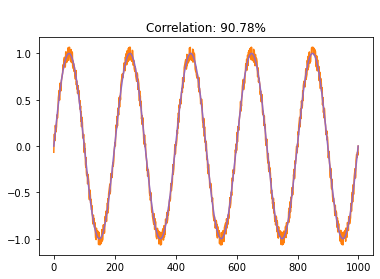

In [230]:
x_range = np.linspace(0, (np.pi * n)/100, n)
X = np.sin(x_range)
Y = generate_noise(X, level=0.4)
c = corr(X, Y)

plot(X, Y, corr=c)

However, it may not be very robust to recognize correlation between two signals with different phases,
unless either the difference in phase is very small or the two signals are symmetrical.

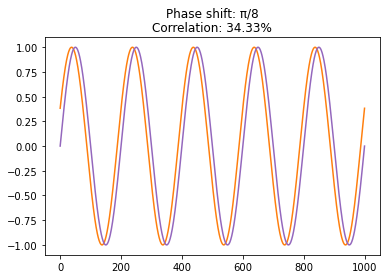

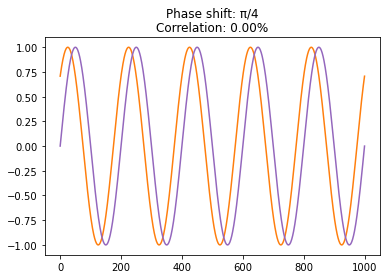

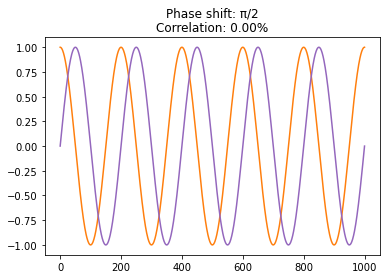

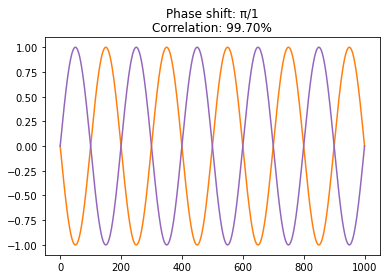

In [219]:
x_range = np.linspace(0, (np.pi * n)/100, n)
X = np.sin(x_range)
    
for phi in range(3, -1, -1):
    Y = np.sin(np.pi/(2 ** phi) + x_range)
    c = corr(X, Y)
    plot(X, Y, corr=c, title=f'Phase shift: π/{int(2 ** phi)}')
